# PROYECTO 1 EDA - VISUALIZACIÓN

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### Cargamos el dataset limpiado anteriormente

In [6]:
df = pd.read_csv('../data/anime_dataset_limpio.csv')
df.sample()

,anime_id,name,score,genres,type,episodes,aired_start,premiered,status,studios,source,rating,rank,popularity,favorites,scored_by
3423,20053,Wizard Barristers: Benmashi Cecil,6.17,"Action, Fantasy",TV,12.0,2014.0,winter 2014,Finished,Arms,Original,PG-13,8008.0,2714,60,23351.0


In [7]:
# --- Conversiones a categóricas ---
df['type']   = df['type'].astype('category')
df['status'] = df['status'].astype('category')
#df['studios'] = df['studios'].astype('category')
df['source'] = df['source'].astype('category')

# rating como categórica ORDENADA
orden_rating = ['G', 'PG', 'PG-13', 'R', 'R+', 'Rx']
df['rating'] = pd.Categorical(df['rating'], categories=orden_rating, ordered=True)

# --- Conversiones a enteros "nullable" (Int64) ---
df['episodes']    = df['episodes'].astype('Int64')
df['aired_start'] = df['aired_start'].astype('Int64')
df['rank']        = df['rank'].astype('Int64')
df['scored_by']   = df['scored_by'].astype('Int64')

In [8]:
df.sample(3)

,anime_id,name,score,genres,type,episodes,aired_start,premiered,status,studios,source,rating,rank,popularity,favorites,scored_by
13971,1900,Twin Signal: Family Game,6.24,"Action, Comedy, Sci-Fi",OVA,3,1996,summer 1996,Finished,NaN,NaN,PG-13,7703,10908,4,763
4266,25267,Megumi to Taiyou II: Kajuu Gummi Tweet Mystery...,4.84,Mystery,Special,1,2012,winter 2012,Finished,"Madhouse, MAPPA",Original,G,12152,11928,0,401
9634,34638,Jitaku Keibiin,6.60,Hentai,OVA,4,2017,winter 2017,Finished,Suzuki Mirano,Visual novel,Rx,<NA>,5432,41,5314


#### Analisis puntuaciones de los animes - Histograma

Ignoro los nulos

In [9]:
df_score = df[df["score"].notna()].copy()

Comprobamos cual es la mayor y menor puntuación.

In [10]:
score_ordenado = df_score.sort_values("score", ascending=False)
mayor_score = score_ordenado["score"].max()
menor_score = score_ordenado["score"].min()

print("Score mínimo:", menor_score)
print("Score máximo:", mayor_score)

Score mínimo: 1.85
Score máximo: 9.1


Realizamos un histograma con las puntuaciones de todos los animes.

Media: 6.44


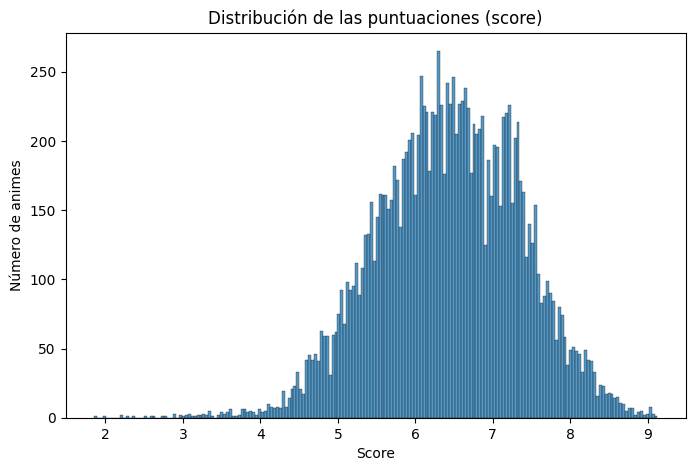

In [11]:
df_score = df[df['score'].notna()].copy()
n = df_score["score"].count()
media = df_score["score"].mean()
print(f"Media: {media:.2f}")

#Usamos la regla de Sturtges para el cálculo del número de clases
k = 1+np.log2(n)**2
h = (mayor_score - menor_score) / k
bins = np.arange(menor_score, mayor_score + h, h)


plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_score,
    x='score',
    bins=bins
)

plt.xlabel("Score")
plt.ylabel("Número de animes")
plt.title("Distribución de las puntuaciones (score)")
plt.show()

La distribución de las notas se concentra entre 5,5 y 7,5 siendo la media de 6,44. También podemos observar como hay escasos valores por debajo de 4 y algo más por encima de 8 siendo algo anecdótico los animes con valoración por encima de 9 puntos. 

#### Análisis de géneros en los anímes - Gráfico de barras

En esta columna tenemos un problema, la gran mayoría de animes no tienen un único género y en el dataset nos indicaba por ejemplo, el conjunto "Comedia y fantasía" como un género concreto. Esto probocaba que tuviesemos cientos de géneros distintos (muchas combinaciones) y para solucionar esto separamos cada uno de los géneros. De esta forma si el anime X tiene como género "Comedia, Fantasía" logramos separarlo en dos filas distintas donde el anime X tendra "Comedia" y otra vez el anime X tendrá "Fantasía".

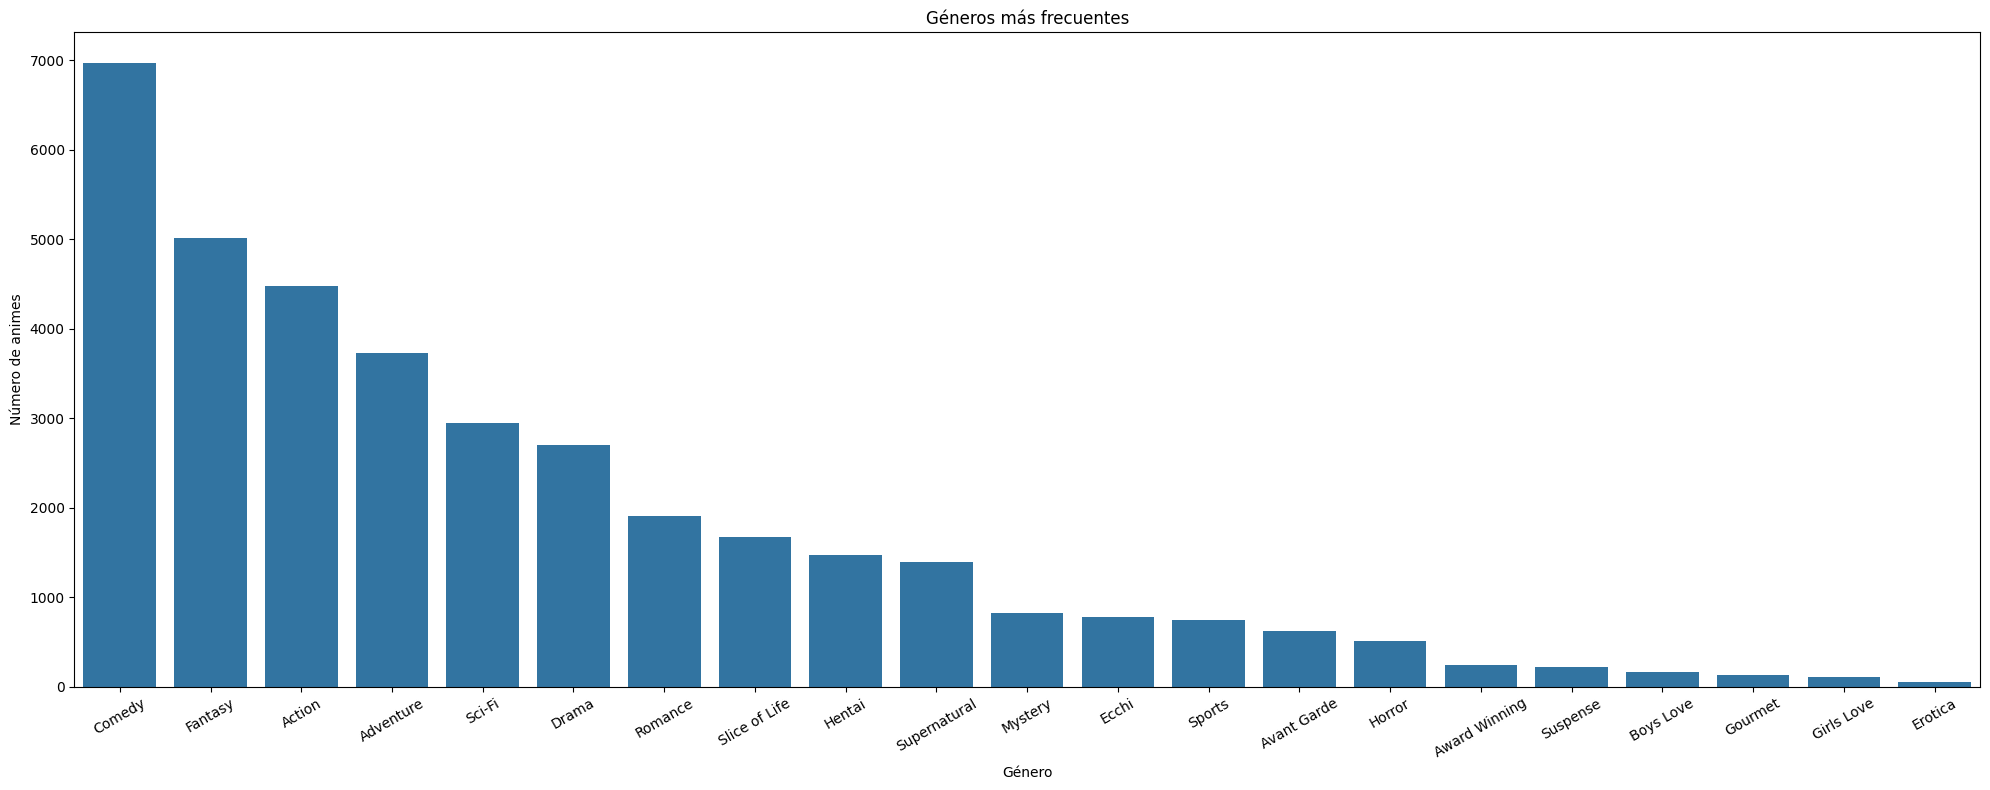

In [12]:
#Elimino los nulos y separo los géneros
generos_aux = (df['genres'].dropna().str.split(', ').explode())

generos_frecuencia = generos_aux.value_counts() #Los cuento

#Realizo el gráfico de barras
plt.figure(figsize=(20, 8))
sns.barplot(x=generos_frecuencia.index, y=generos_frecuencia.values)

plt.xlabel('Género')
plt.ylabel('Número de animes')
plt.title('Géneros más frecuentes')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

De esta forma podemos observar como, con bastante diferencia, tenemos el género de comedia como el más repetido entre los animes. Está seguido de fantasía, acción y aventura que en muchas ocasiones estos géneros pueden ir juntos en un mismo anime.

#### Puntuación media por género - Diagrama de cajas y bigotes

A continuación analizamos la distribución de las puntuaciones por género. Para ello utilizamos un diagrama de cajas y bigotes, que permite observar no solo la nota media, sino también la dispersión de los datos y la presencia de posibles outliers (valores atípicos) en cada género.

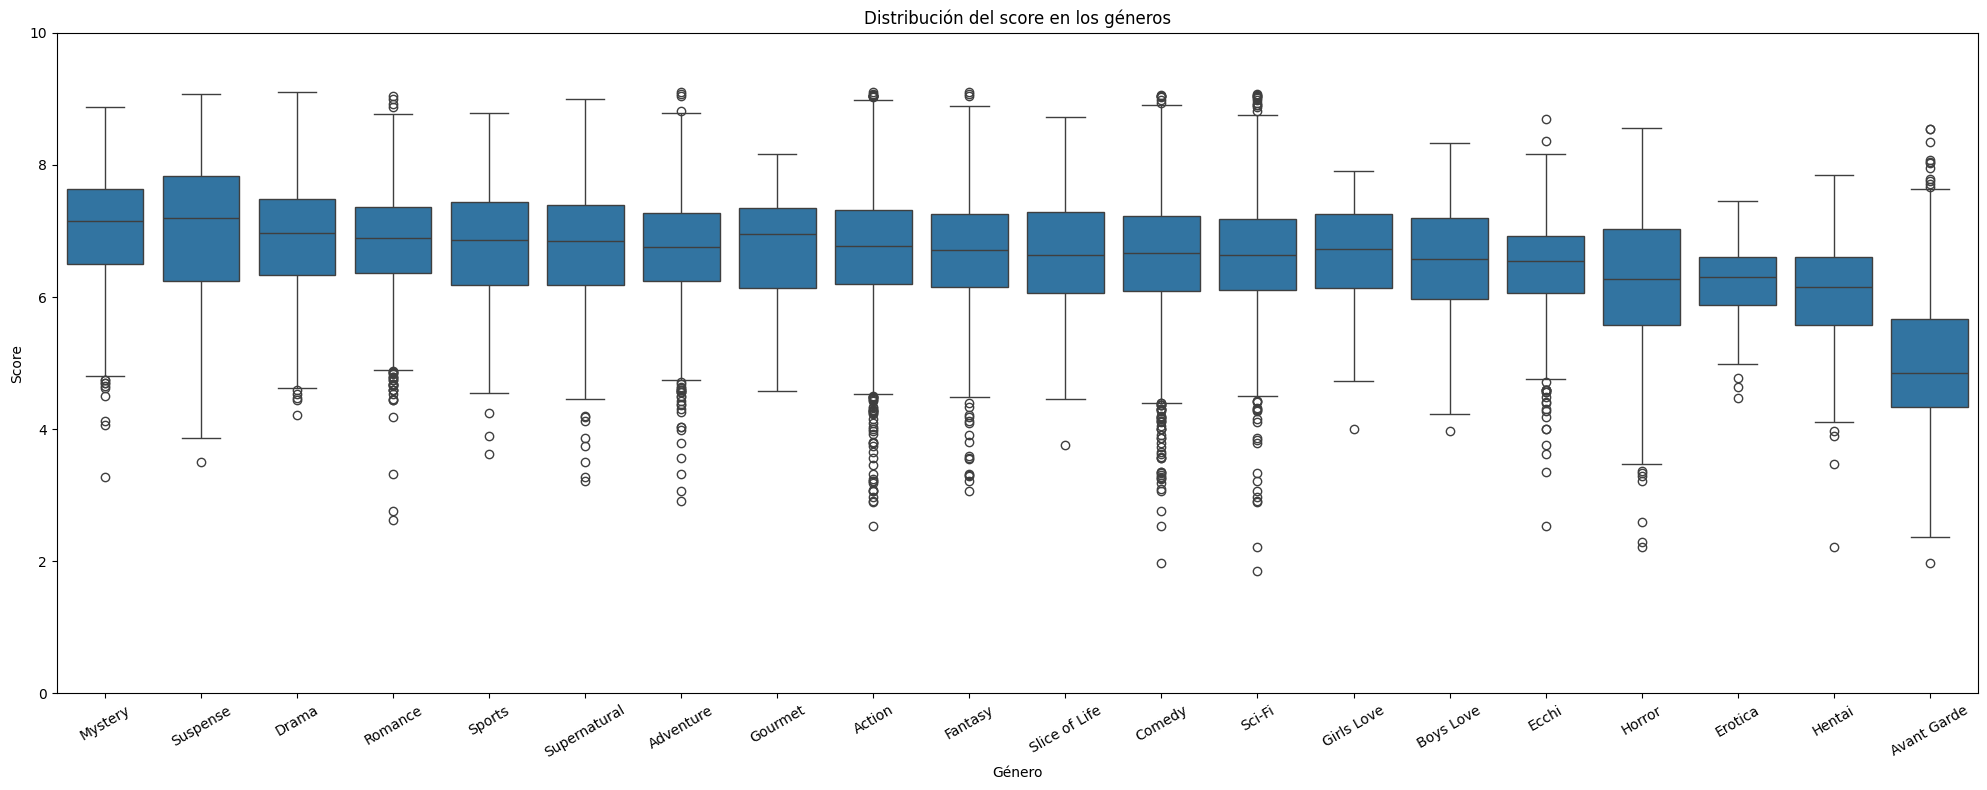

In [13]:
dg = df[['genres', 'score', 'scored_by']].dropna(subset=['genres', 'score', 'scored_by']).copy()

dg['genre'] = dg['genres'].str.split(', ')
dg = dg.explode('genre')

#Eliminamos el genero "premiados" que son animes que han recibido algun premio pero no es un genero como tal
dg = dg[dg['genre'].str.lower() != 'award winning']
dg = dg[dg['scored_by'] > 199]

# 1) Nota media por género
score_medio_genero = (
    dg.groupby('genre')['score']
      .mean()
      .sort_values(ascending=False)
)

# 3) Nos quedamos solo con esos géneros
dg_top = dg[dg['genre'].isin(score_medio_genero.index)].copy()

# 4) Diagrama de cajas y bigotes
plt.figure(figsize=(20, 8))
sns.boxplot(
    data=dg_top,
    x='genre',
    y='score',
    order=score_medio_genero.index   # para que salgan en el orden de la media
)

plt.xlabel('Género')
plt.ylabel('Score')
plt.title('Distribución del score en los géneros')
plt.xticks(rotation=30)
plt.ylim(0, 10)
plt.tight_layout()
plt.show()


En conjunto, los géneros con mejores valoraciones son Mystery, Suspense, Drama y Romance, que presentan medianas de score más altas y cajas relativamente compactas, indicando puntuaciones buenas y bastante consistentes entre títulos. En el extremo contrario, géneros como Ecchi, Horror, Erotica, Hentai y Avant Garde muestran medianas algo más bajas y una mayor dispersión, con numerosos valores atípicos hacia puntuaciones bajas.

Si lo ponemos en contexto con el número de animes por género, se observa que algunos de estos géneros con puntuaciones más extremas cuentan con muchos menos títulos, por lo que unos pocos animes influyen mucho en su distribución. En cambio, géneros muy frecuentes como Comedy, Action o Fantasy tienen distribuciones más estables y representativas del conjunto de obras que los componen.

#### Puntuación media por año - Gráfico de barras

En esta ocasión pretendemos analizar la puntuación media de los animes por año y de esta forma observar si hay algún cambio significativo a lo largo de los años.

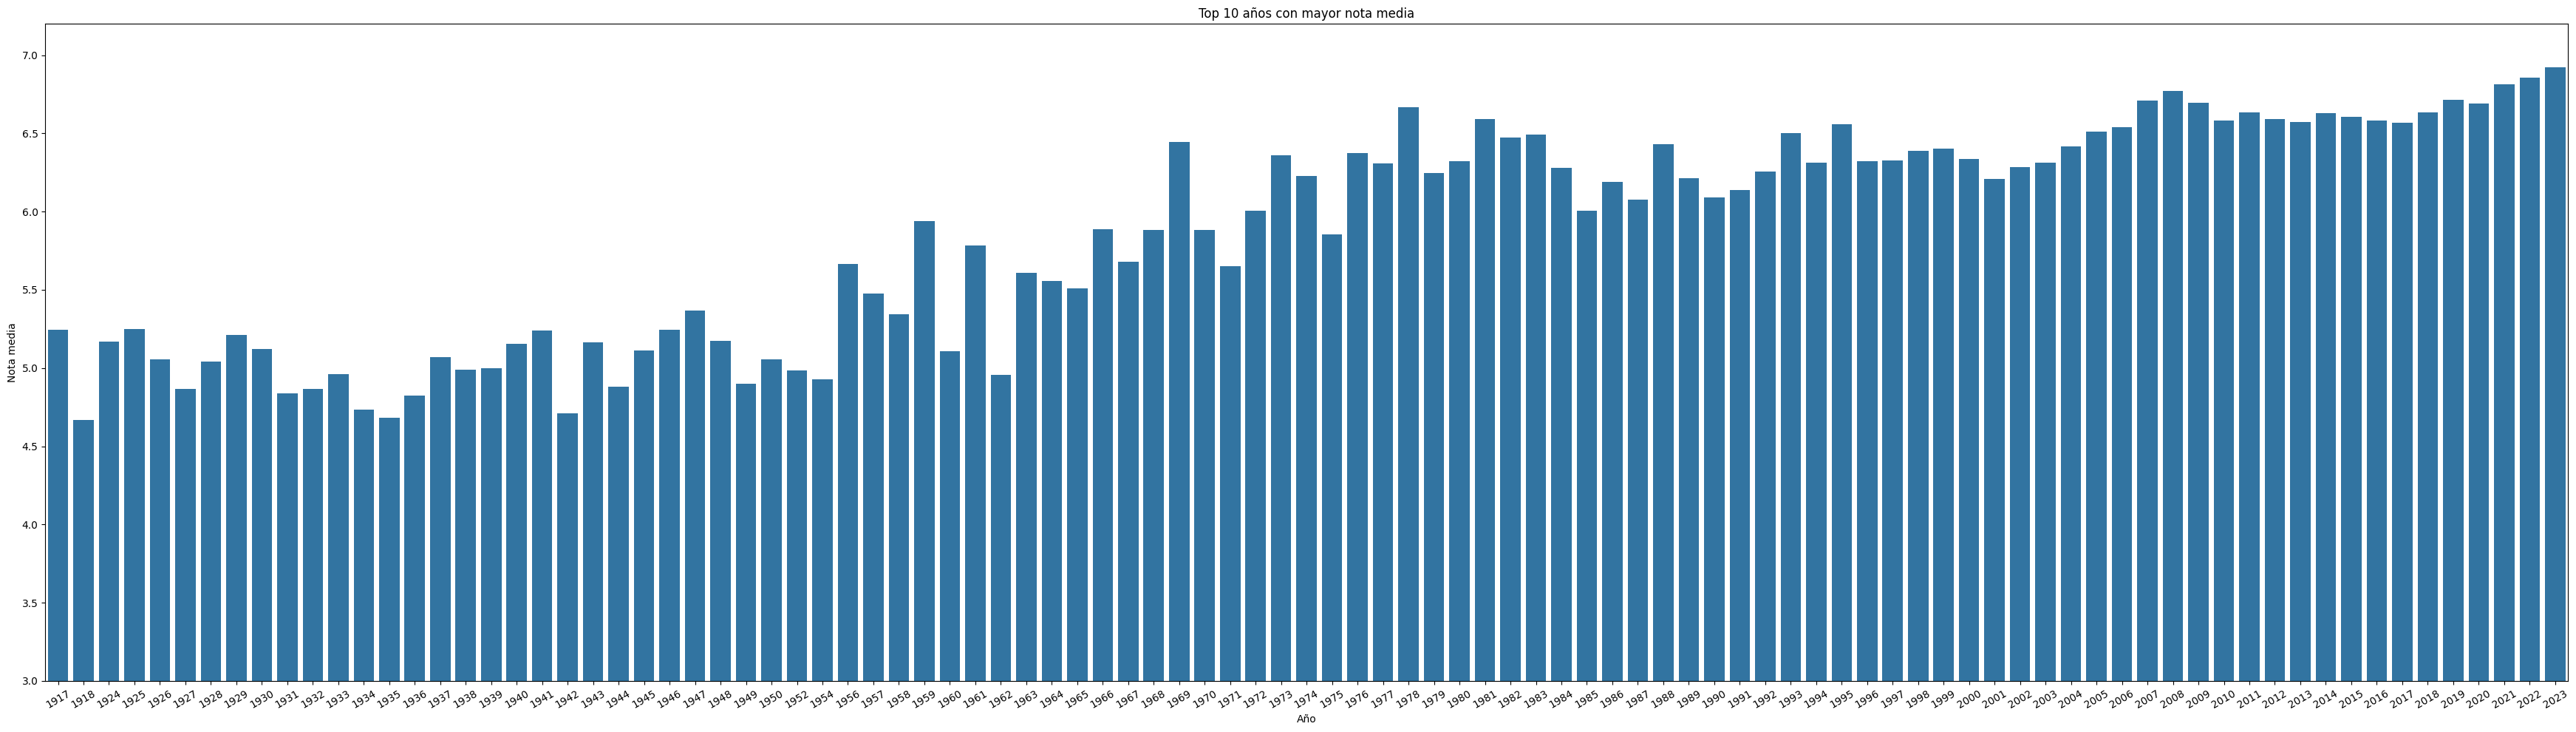

In [14]:
#Nos quedamos solo con filas que tengan genres, scored y scored_by
dg = df[['aired_start', 'score', 'scored_by']].dropna(subset=['aired_start', 'score', 'scored_by']).copy()

#Nos quedamos con los animes que tengan mas de 200 valoraciones por parte de los usuarios, para de esta forma eliminar puntuaciones que tengan muy pocas valoraciones y puedan manchar la media
dg = dg[dg['scored_by'] > 199]

#Agrupo por año de inicio y hago la media del score
score_medio_año = (dg.groupby('aired_start')['score'].mean().sort_values(ascending=False))

#Gráfica de barras
plt.figure(figsize=(35, 10))
sns.barplot(x=score_medio_año.index, y=score_medio_año.values)

plt.xlabel('Año')
plt.ylabel('Nota media')
plt.title('Top 10 años con mayor nota media')
plt.xticks(rotation=30)
plt.ylim(3, 7.2)   # <-- aquí marcas mínimo y máximo del eje Y
plt.tight_layout()
plt.show()

Tras esto podemos concluir como cada año, de media, hay mejores animes. En los primeros años se encuetran las peores valoraciones, algo lógico al ver los aspectos técnicos de la época y como la mayoria de estos eran pequeños cortos. Cabe destacar algunos años entre 1960 y 2000 con picos muy significativos en los que encontraremos, seguramente, alguna serie más famosa y mejor valorado de lo normal. A partir de los 2000 observamos como asciende de forma más suave.

#### Animes estrenados por año - Gráfico de puntos

En esta ocasión vamos a analizar la evolución de los animes estrenados a lo largo de los años. Para este análisis vamos a quitar el 2023 porque el dataset es creado este año y, posiblemente a mediados del año por lo que no tiene todos los animes de ese año.

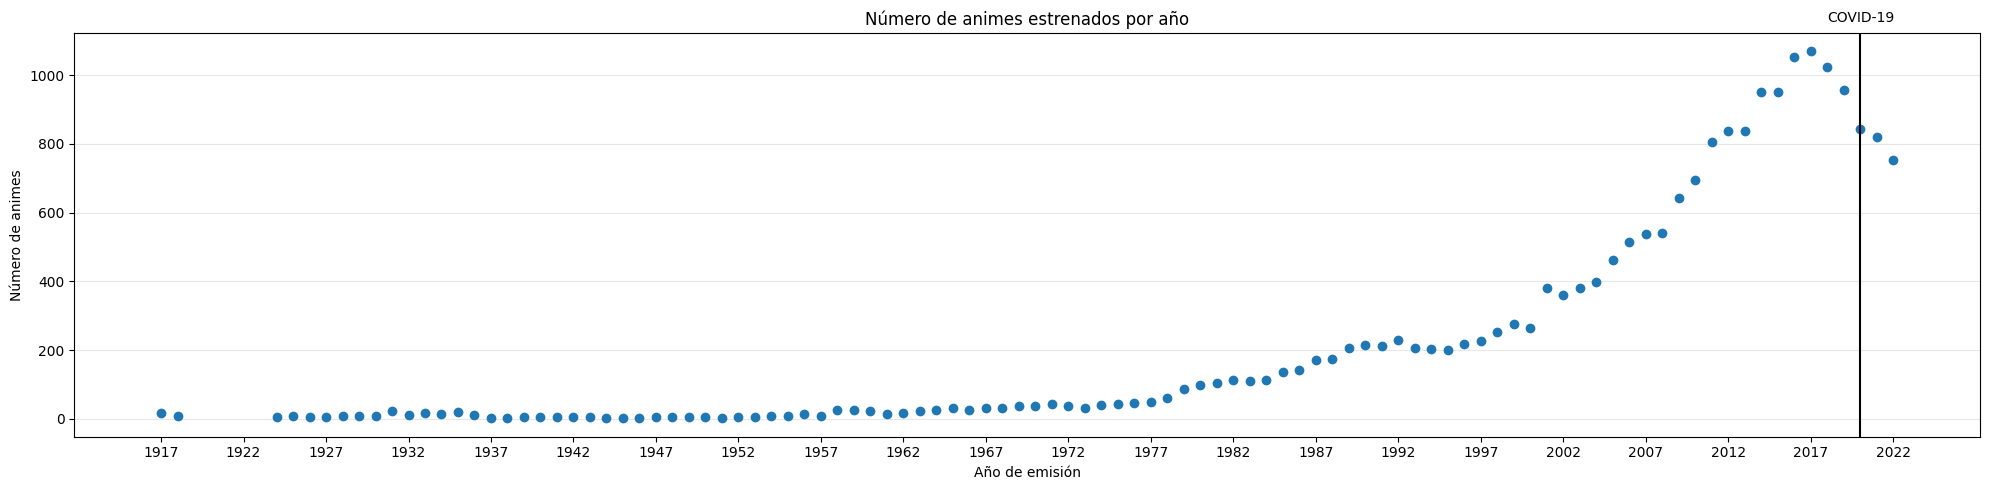

In [15]:
#Quito los animes de 2023 porque es un año inclompleto en el dataset
dg = df[(df["aired_start"].notna()) & (df["aired_start"] < 2023)]

# Agrupar por año y contar animes
animes_por_anio = (dg.groupby('aired_start')['anime_id'].count().sort_index())


plt.figure(figsize=(20, 5))
plt.plot(animes_por_anio.index, animes_por_anio.values, 'o')
plt.xticks(range(1917, 2023 + 1, 5))
plt.xlabel('Año de emisión')
plt.ylabel('Número de animes')
plt.title('Número de animes estrenados por año')
plt.grid(True, axis='y', alpha=0.3)

ax = plt.gca()

# Línea vertical en 2020 indicando el covid
ax.axvline(x=2020, color='black')

#Leyenda indicando el covid
ax.text(
    2020, 1.02, 'COVID-19',
    transform=ax.get_xaxis_transform(),  # x en datos, y en [0,1] del eje
    ha='center', va='bottom',
    clip_on=False
)
plt.tight_layout()
plt.show()


Con este análisis observamos cuatro claras secciones:
- Entre 1917 y 1960 apenas se estrenaban animes habiendo algunos años donde no tenemos ningún dato (posiblemente por nulo en el dataset).
- Entre 1960 y 2000 comienza un claro aumento en la producción de los animes.
- Entre 2000 y 2017 un aumento muy brusco de la cantidad de animes gracias a su popularidad y una mayor exportación al exterior.
- Entre 2017 y act. una clara bajada en la producción de series, posiblemente se vea afectado por el covid pero observamos como esta bajada ya comenzó unos años antes. 

Hemos podido observar, como era de esperar, un aumento muy significativo en el número de animes aunque destaca la bajada de los últimos años.

#### Numero de animes por tipo - Diagrama de líneas

A continuación vamos a analizar la evolución de los animes según su genero. Vamos a iniciar en el 1971 ya que anteriormente el número de animes es muy escaso y no nos da tanto análisis. Vamos a explicar cada tipo:

- **TV**: Series emitidas en televisión, suelen tener temporadas con varios episodios semanales. Es el formato más común.

- **ONA (Original Net Animation)**: Animes lanzados directamente en plataformas digitales o streaming, sin pasar por televisión ni cine (igual que TV pero en plataforma digital).

- **OVA (Original Video Animation)**: Episodios o series producidos para distribución directa en formato físico (DVD, Blu-ray), sin emisión previa. Suelen tener mayor calidad o contenido especial.

- **Movie**: Películas de anime estrenadas en cines o plataformas. Tienen mayor duración y presupuesto que los episodios de TV.

- **Special**: Episodios extra o especiales que complementan una serie principal. Pueden ser recapitulaciones, historias paralelas o contenido promocional.

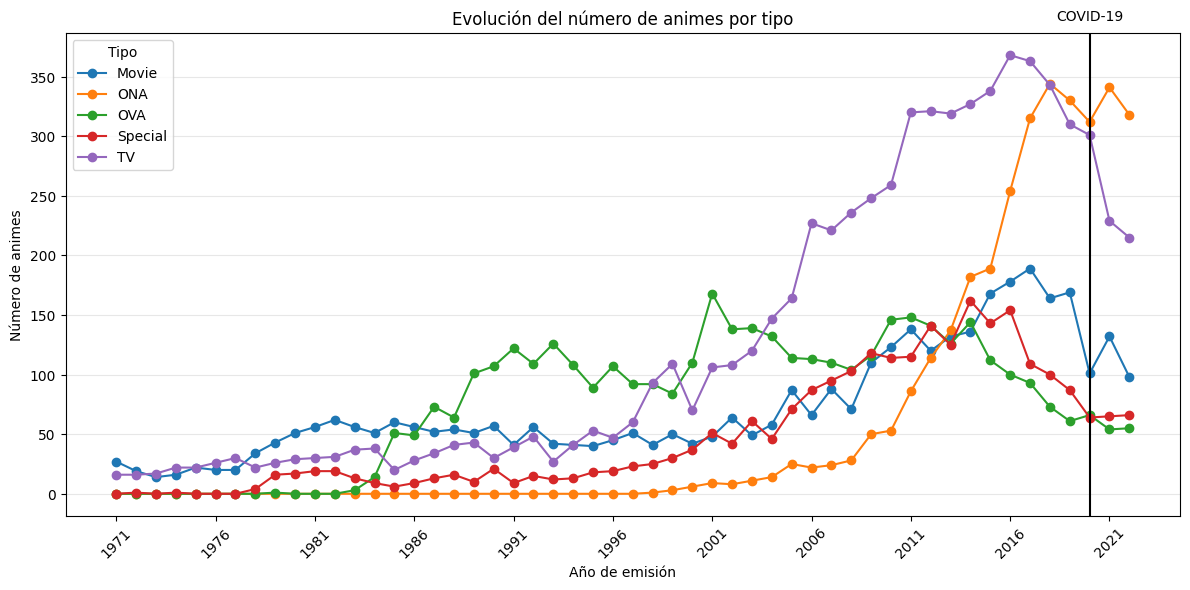

In [16]:
#Filtrar filas con aired_start y type NO nulos, desde 1971 a 2022
dg = df.dropna(subset=['aired_start', 'type']).copy()
dg = dg[(dg["aired_start"] > 1970) & (dg["aired_start"]< 2023)]

#Contar animes por año y tipo
animes_por_anio_tipo = (dg.groupby(['aired_start', 'type'])['anime_id'].count().reset_index(name='count'))

#Pasar a tabla: filas = años, columnas = tipos, valores = nº animes
tabla = (animes_por_anio_tipo.pivot(index='aired_start', columns='type', values='count').fillna(0))


#Gráfico de lineas, una linea por tipo
plt.figure(figsize=(12, 6))

for tipo in tabla.columns:
    plt.plot(tabla.index, tabla[tipo], marker='o', label=str(tipo))

plt.xlabel('Año de emisión')
plt.ylabel('Número de animes')
plt.title('Evolución del número de animes por tipo')
plt.grid(axis='y', alpha=0.3)

anio_min = int(tabla.index.min())
anio_max = int(tabla.index.max())
plt.xticks(range(anio_min, anio_max + 1, 5), rotation=45)

ax = plt.gca()

# Línea vertical en 2020 indicando covid
ax.axvline(x=2020, color='black')

#leyenda indicando covid
ax.text(
    2020, 1.02, 'COVID-19',
    transform=ax.get_xaxis_transform(),
    ha='center', va='bottom',
    clip_on=False
)

plt.legend(title='Tipo', loc='upper left')
plt.tight_layout()
plt.show()



Con este gráfico realizar un análisis muy interesante. Vemos como en desde 1985 hasta 2002 el tipo **OVA** era de lo más común, sin embargo ya desde los finales de los noventa el tipo **TV** comenzaba a subir. Tanto la categoría de **Special** y **Movie** siguen una evolución similar a la cantidad de animes, sin destacar especialmente salvo las películas durante unos años sobre 1980. Lo más interesante lo vemos a partir del siglo XXI cuando **TV** y **ONA** se disparan. Especialmente los **ONA** crecen a partir de 2014 llegando estos últimos años a superar al estilo tradicional de emisión de anime. Es interesante observar como el **OVA**, que esta orientado a vender en formato físico, comienza su mayor declibe en el momento donde los **ONA** crecen más rápidamente. Tiene bastante lógica al tratarse de dos formatos totalmente opuestos y al final, con el aumento estos últimos años de plataformas digitales de streaming tiene pinta que este número seguirá aumento. Ver también como en el año del Covid estos animes estrenados en plataformas digitales se vieron aumentados significativamente y seguramente el aumento de películas se deba también a películas estrenadas en plataformas digitales. Un gráfico muy interesante en que observamos patrones fuera del anime como por ejemplo el aumento general de plataformas digitales y la clara disminución de contenido físico.

#### Estudios de animación con más animes - Gráfico de barras

A continuación vamos a realizar un análisis muy simple sobre la cantidad de animes producidos por cada estudio de animación.

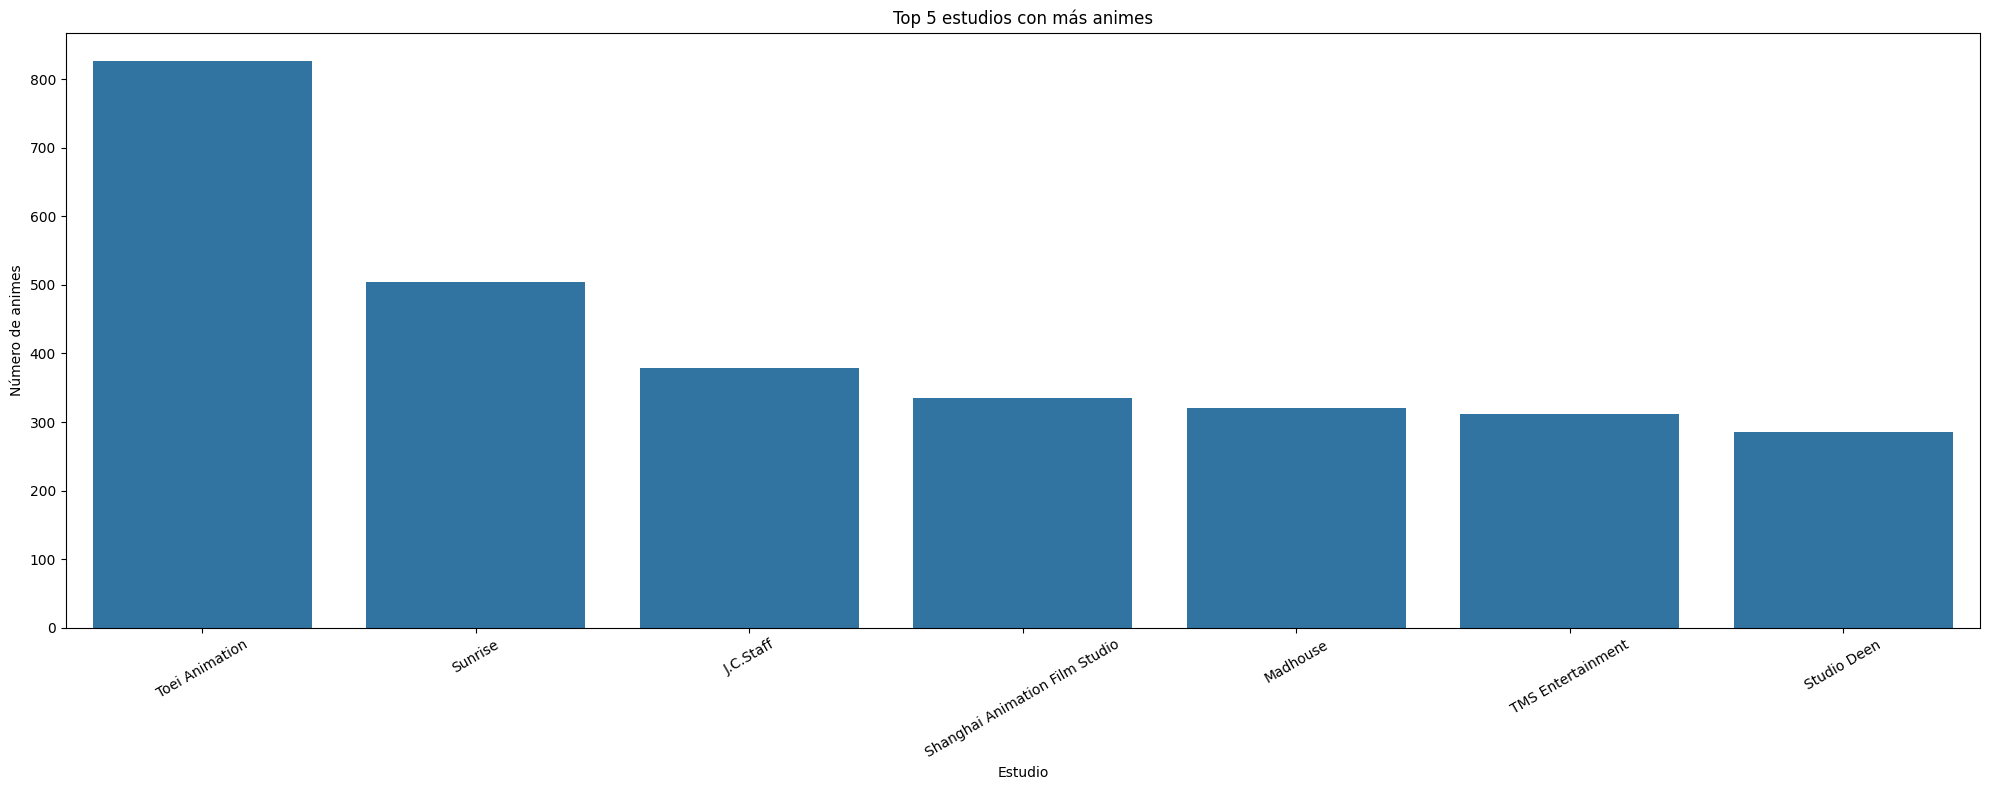

In [17]:
#Nos quedamos con los valores no nulos de la columan
estudios = df[df["studios"].notna()]

n_estudios = estudios["studios"].value_counts().head(7)

plt.figure(figsize=(20, 8))
sns.barplot(
    x=n_estudios.index.astype(str),   # convertimos el índice a strings normales
    y=n_estudios.values              # los valores como array
)

plt.xlabel('Estudio')
plt.ylabel('Número de animes')
plt.title('Top 5 estudios con más animes')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Podemos observar los 7 estudios de animación con más animes a lo largo de la historia. Vemos como *Toei Animation* destaca entre los demas que tienen unos valores similares.

#### Cantidad de animes en tramo de episodios - Grafico de barras

Vamos a analizar que cantidad de animes tenemos en los siguientes tramos de capítulos: <= 13, 14-26, 27-52, 53-100 y > 100. Vamos a quitar los animes con 1 y 2 episodios no contar películas y especiales de únicamente un par de capítulos, de esta forma tratamos de contar únicamente lo que son series. 

In [18]:
def clasificar_longitud(e):
    if e <= 12:
        return '≤ 13'
    elif e <= 26:
        return '14–26'
    elif e <= 52:
        return '27–52'
    elif e < 100:
        return '53-100'
    else:
        return '> 100'

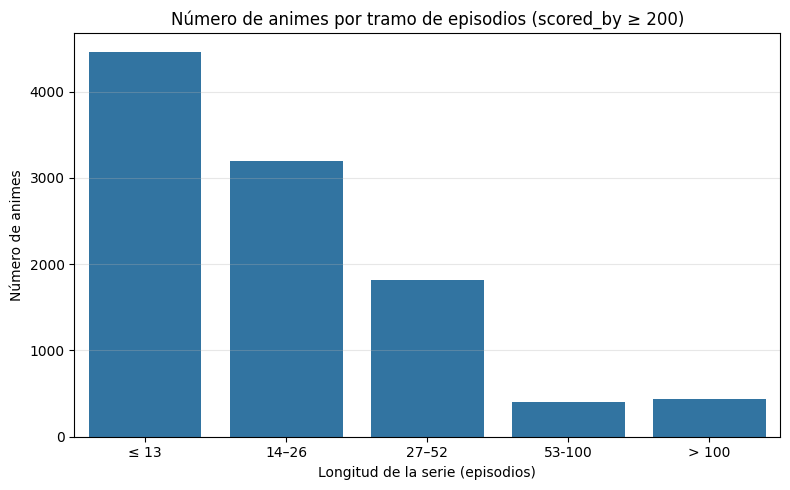

In [19]:
#Filtramos > 2 capitulos y aplicamos la funcion para devolver el string
dg = dg[dg["episodes"] > 2]
dg['length_cat'] = dg['episodes'].apply(clasificar_longitud)

#COntamos el número de animes y aplicamos un orden, al ser string no podemos ordenarlos de otra forma
conteo_long = (dg['length_cat'].value_counts().reindex(['≤ 13', '14–26', '27–52', '53-100', '> 100']))

#Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(x=conteo_long.index, y=conteo_long.values)

plt.xlabel('Longitud de la serie (episodios)')
plt.ylabel('Número de animes')
plt.title('Número de animes por tramo de episodios (scored_by ≥ 200)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Como era de esperar, los animes con 13 o menos capítulos son los más frecuentes con mucha diferencia y animes mucho más largos con más de 53 episodios son muy escasos. Es algo lógico debido a la complejidad y gasto de dinero que supone crear los capítulos, además, de que creaer hsitorias largas también es mucho más complicado.

#### Media de favoritos por tramo de episodios - Gráfico de barras

Ya hemos visto que la gran mayoría de animes son de pocos capítulos, pero eso no quiere decir que los usuarios lo prefieran. Por eso con este gráfico pretendemos analizar si los favoritos de los usuarios son animes más o menos largos.

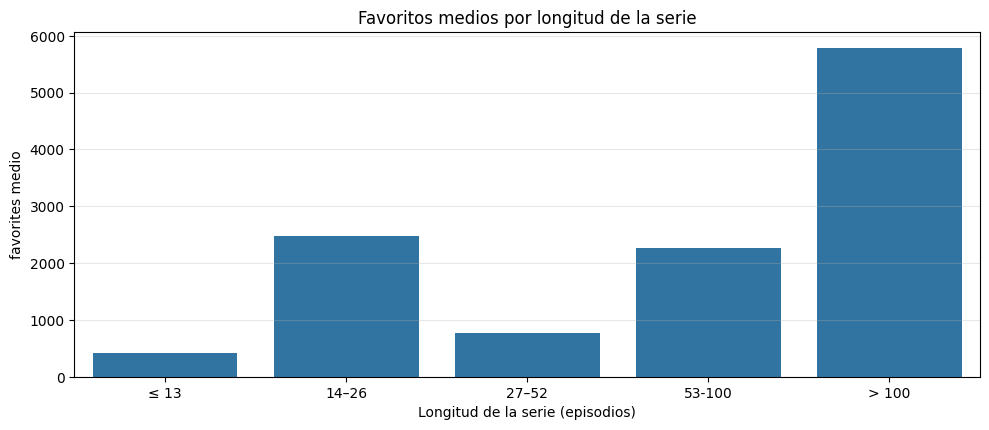

In [20]:
#Partimos solo de filas con episodios, scored_by y favorites
dg = df[['episodes', 'scored_by', 'favorites']].dropna().copy()

#Filtro de votos mínimos
dg = dg[dg['scored_by'] >= 200]

#Aplicamos la funcion para los tramos de episodios
dg['length_cat'] = dg['episodes'].apply(clasificar_longitud)

#Calcular medias por tramo
pop_por_long = (dg.groupby('length_cat')[['scored_by', 'favorites']].mean().reindex(['≤ 13', '14–26', '27–52', '53-100', '> 100']))

#Gráfico
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 2)
sns.barplot(
    x=pop_por_long.index,
    y=pop_por_long['favorites']
)
plt.xlabel('Longitud de la serie (episodios)')
plt.ylabel('favorites medio')
plt.title('Favoritos medios por longitud de la serie')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Sorprendentemente consguimos un gráfico bastante opuesto al anterior y esto nos dice que los usuarios prefieren cláramente los animes largos. Podemos pensar que los animes cortos al ser mucho más frecuentes también hay muchos con peores valoraciones indicando que gustan menos a la gente. Además, mantener la constancia de animes largos requiere una grandísima cantidad de dinero que si no logra la popularidad de los usuarios no podra mantener el costo. Por tanto es normal pensar que los favoritos sean los animes con más episodios porque si no no se podría haber alcanzado ese número de capítulos.

#### Número de animes por año y tipo

En esta ocasión queremos analizar como han evolucionado los animes de los 5 principales géneros: Comedia, Fantasía, Acción, Aventura y Sci-Fi. Para que pueda ser legible hemos seleccionado los animes de este siglo para no tener demasiados datos en la gráfica y no se pudiese leer bien.

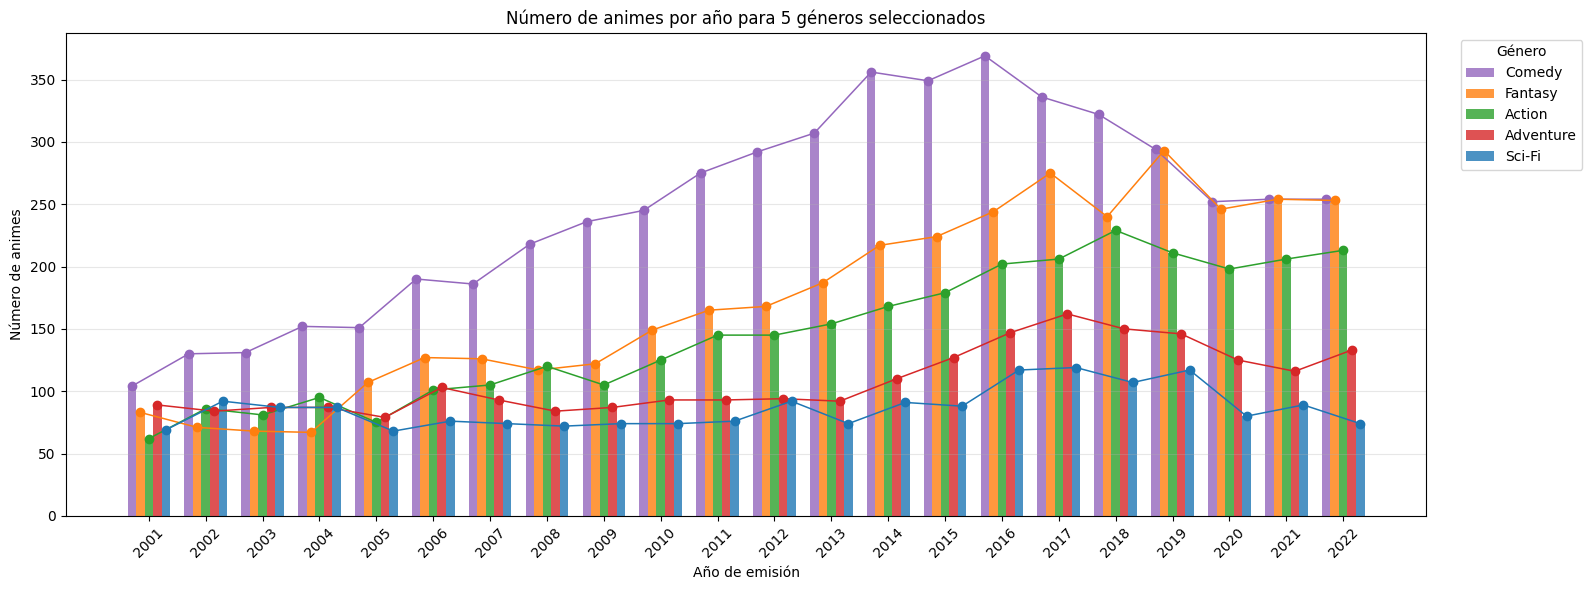

In [21]:
# Géneros y colores
target_genres = ['Comedy', 'Fantasy', 'Action', 'Adventure', 'Sci-Fi']
colors = ['tab:purple', 'tab:orange', 'tab:green', 'tab:red', 'tab:blue']

#Eliminamos nulos y cogemos animes del siglo XXI
dg_generos = df.dropna(subset=['aired_start', 'genres']).copy()
dg_generos = dg_generos[(dg_generos['aired_start'] >= 2001) &(dg_generos['aired_start'] <= 2022)]

#Separamos los generos
dg_generos['genres_list'] = dg_generos['genres'].str.split(', ')
dg_generos = dg_generos.explode('genres_list')

#Nos quedamos con el top5 generos
dg_filtrado = dg_generos[dg_generos['genres_list'].isin(target_genres)]

#Numero de animes
conteo = (dg_filtrado.groupby(['aired_start', 'genres_list'])['anime_id'].nunique().reset_index(name='count'))

# 5) Tabla: filas = años, columnas = géneros
tabla_gen = (
    conteo
    .pivot(index='aired_start', columns='genres_list', values='count')
    .reindex(columns=target_genres)
    .fillna(0)
)

anios = tabla_gen.index.values
n_anios = len(anios)
n_genres = len(target_genres)

x_base = np.arange(n_anios)   # una posición por año
width = 0.15                  # ancho de cada barra

plt.figure(figsize=(16, 6))

#Dibujamos las barras y rectas de colores

for i, genre in enumerate(target_genres):
    x_pos = x_base + (i - (n_genres-1)/2) * width
    y_vals = tabla_gen[genre].values

    # Barras
    plt.bar(
        x_pos, y_vals,
        width=width,
        color=colors[i],
        alpha=0.8,
        label=genre
    )

    # Polilínea
    plt.plot(
        x_pos, y_vals,
        marker='o',
        linewidth=1.1,
        color=colors[i]
    )

plt.xlabel('Año de emisión')
plt.ylabel('Número de animes')
plt.title('Número de animes por año para 5 géneros seleccionados')
plt.xticks(x_base, anios, rotation=45)
plt.legend(title='Género', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()





Podemos observar como el género principal comenzo a subir, mucho más rápido que el resto, a principios de años y sin embargo estos últimos años se ve una tendencia a la baja llegando incluso la fantasía a igualarle con pryección de superar. La ciencia ficción, en cambio, se ha visto muy estable con una pequeña caida estos últimos años, lo que indica que tiene pinta que acabará siendo superado por el drama. Cabe destacar como la fantasía que a principios de año era la que menos animes tenía, se ha convertido ahora mismo en la moda de los animes. además también ha visto un gran aumento los animes de fantasía, posiblemende debido a la conbinación de fantasía y acción dentro de los animes.

### Conclusión final

En conjunto, el análisis realizado ha resultado muy útil para entender no solo la evolución de los animes, sino también algunos cambios en la propia sociedad. A través de las distribuciones, series temporales y comparaciones por géneros y tipos, se observa claramente cómo la digitalización impulsó un fuerte aumento en la producción, coincidiendo con la expansión global de la cultura japonesa. Esto facilitó que el anime dejara de ser un producto casi exclusivo del público japonés y se adaptara progresivamente a gustos más internacionales.

Del mismo modo, la aparición de las plataformas de *streaming* en los últimos años ha provocado un cambio evidente en los formatos producidos. Tipos tradicionales como **TV** o las **OVA**, muy ligadas a la emisión lineal y a la venta en físico, han perdido peso relativo frente al formato **ONA**, mucho más alineado con el consumo bajo demanda. En resumen, el dataset no solo permite estudiar características internas del anime (puntuaciones, géneros, número de episodios…), sino que también refleja, de forma indirecta, cómo han cambiado los hábitos de consumo y la industria del entretenimiento a nivel global.

No obstante, el análisis está condicionado por las características y limitaciones del propio dataset (fuente de datos, posibles sesgos en las valoraciones de los usuarios o en los títulos más visibles). Como trabajo futuro, sería interesante combinar esta información con otros conjuntos de datos (por ejemplo, datos de emisión, audiencia o recaudación) para obtener una visión aún más completa de la relación entre la producción de anime, su recepción por parte del público y las transformaciones del mercado audiovisual.